## **Imports**

In [349]:
import os
import joblib
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.stats import zscore

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

## **Paths & Global Variables**

In [350]:
ROOT_PATH = r"C:\Users\mario\OneDrive\Documents\Work\Side Hustles\Kaggle\titanic"

import sys

sys.path.append(ROOT_PATH)

from titanic.config import PROCESSED_DATA_DIR, MODELS_DIR

## **Reading Data**

In [351]:
os.chdir(PROCESSED_DATA_DIR)

total_df = pd.read_parquet("titanic_processed.parquet")

X_train = pd.read_parquet("X_train.parquet")
y_train = pd.read_parquet("y_train.parquet")

X_test = pd.read_parquet("X_test.parquet")
y_test = pd.read_parquet("y_test.parquet")

# **Logistic Regression**

## **Assumptions** 🔴

In [352]:
# Binary target
print(total_df.survived.value_counts())

survived
False    967
True     340
Name: count, dtype: int64


In [353]:
# Independent observations
total_df.index.nunique() == total_df.shape[0]

True

In [354]:
# Large enough sample
# At least 10 samples per feature for the smallest class in the outcome variable.
max_features = min(total_df.survived.value_counts() / 10)
num_features = X_train.shape[1]
print(max_features)
print(num_features)
X_train.shape[1] <= max_features

34.0
17


True

c:\Users\mario\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


<Axes: >

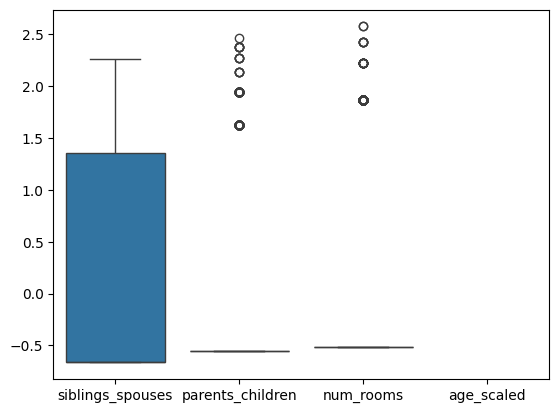

In [355]:
# No influential outliers
sns.boxplot(data=np.log(X_train.iloc[:,0:4] + 0.01).apply(zscore))

<Axes: xlabel='fare_log', ylabel='survived'>

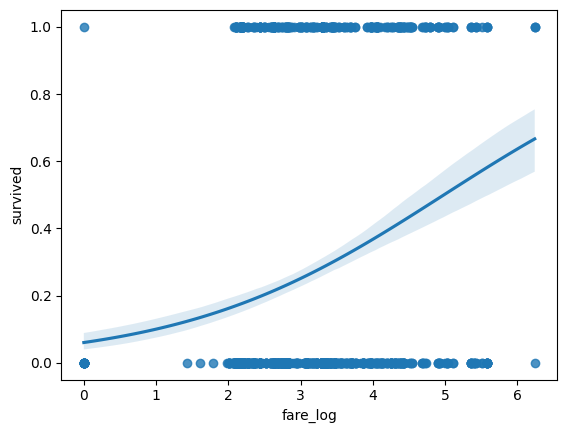

In [356]:
# Features Linearly Related to Log-odds
sns.regplot(
    x="fare_log",
    y="survived",
    data=total_df,
    logistic=True,
)

<Axes: >

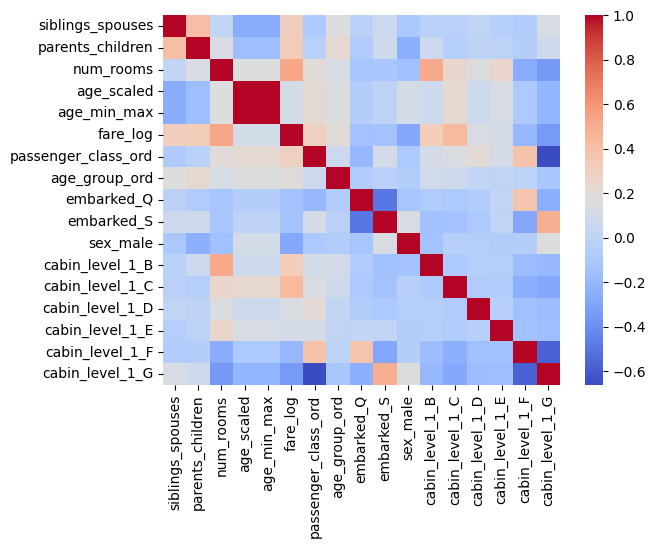

In [357]:
# Multicollinearity
sns.heatmap(X_train.corr(), cmap="coolwarm")

In [358]:
# Variables with high correlation with each other should be removed (r > 0.75)
multicolin_vars = X_train.columns[X_train.corr().abs().sum() > 1.5]
print(multicolin_vars)

Index(['siblings_spouses', 'parents_children', 'num_rooms', 'age_scaled',
       'age_min_max', 'fare_log', 'passenger_class_ord', 'age_group_ord',
       'embarked_Q', 'embarked_S', 'sex_male', 'cabin_level_1_B',
       'cabin_level_1_C', 'cabin_level_1_D', 'cabin_level_1_E',
       'cabin_level_1_F', 'cabin_level_1_G'],
      dtype='object')


In [359]:
cols_to_remove = ["parents_children","num_rooms","age_min_max","age_group_ord","passenger_class_ord"]
X_train.drop(columns=cols_to_remove, inplace=True)
X_test.drop(columns=cols_to_remove, inplace=True)

## **Model Fitting**

### **Balance Class Weight**

In [360]:
log_reg = LogisticRegression(class_weight="balanced")

# finds the coefficients and the intercept value
log_reg.fit(X_train, y_train)

c:\Users\mario\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(class_weight='balanced')

## **Model Testing**

### **Classification Threshold**

In [361]:
THRESHOLD = 0.5
# Doesn't affect Gini acore but affects the confusion matrix
# Do you want to be more sensitive to false positives or false negatives?

In [362]:
y_predicted_probs = log_reg.predict_proba(X_test)[:, 1]
if THRESHOLD == 0.5:
    y_predicted = log_reg.predict(X_test)
else:
    y_predicted = (y_predicted_probs > THRESHOLD) * 1.0

In [363]:
y_predicted_df = pd.DataFrame(y_predicted, columns=["predicted"], index=X_test.index)
y_predicted_probs_df = pd.DataFrame(y_predicted_probs, columns=["probability"], index=X_test.index)
y_predicted_df = pd.concat([y_predicted_df, y_predicted_probs_df], axis=1)
y_predicted_df.head()

,predicted,probability
passenger_id,,
161,False,0.102111
127,False,0.247896
429,False,0.247896
423,False,0.126362
566,False,0.114851


## **Evaluation Metrics**

In [364]:
test_conf_matrix = pd.DataFrame(
    confusion_matrix(y_test, y_predicted),
    index=["actual no", "actual yes"],
    columns=["predicted no", "predicted yes"],
)

test_conf_matrix

,predicted no,predicted yes
actual no,91,19
actual yes,16,52


In [365]:
metrics_dict = {
    "Accuracy": accuracy_score(y_test, y_predicted),
    "Precision": precision_score(y_test, y_predicted),
    "Recall": recall_score(y_test, y_predicted),
    "F1 Score": f1_score(y_test, y_predicted),
}

metrics_df = pd.DataFrame(
    metrics_dict.values(), index=metrics_dict.keys(), columns=["Value"]
)

roc_auc = roc_auc_score(y_test, y_predicted_probs)
gini = 2 * roc_auc - 1

metrics_df.loc["ROC AUC"] = roc_auc
metrics_df.loc["Gini"] = gini

metrics_df

,Value
Accuracy,0.803371
Precision,0.732394
Recall,0.764706
F1 Score,0.748201
ROC AUC,0.858757
Gini,0.717513


## **Feature Importance**

C:\Users\mario\AppData\Local\Temp\ipykernel_25616\2882998531.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


<Axes: xlabel='Coefficient', ylabel='Feature'>

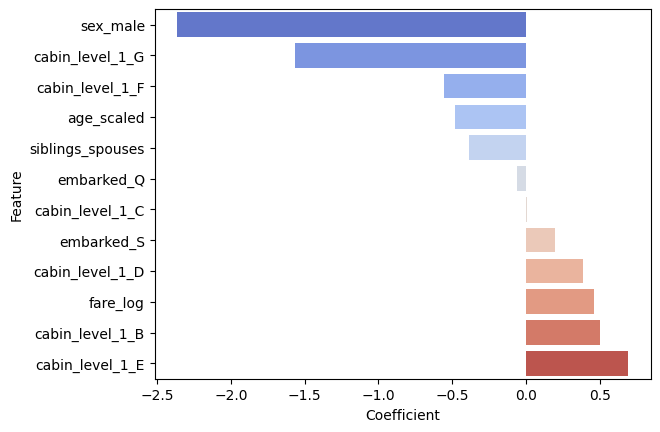

In [366]:
coefficients_df = pd.DataFrame(
    {"Feature": log_reg.feature_names_in_, "Coefficient": log_reg.coef_.flatten()}
)

sns.barplot(
    x="Coefficient",
    y="Feature",
    data=coefficients_df.sort_values("Coefficient"),
    palette="coolwarm",
)

## **Model & Prediction Export**

In [ ]:
os.chdir(MODELS_DIR)
# Save model
joblib.dump(log_reg, "log_reg-model.joblib")
y_predicted_df.to_parquet("log_reg-y_predicted.parquet")